Нам предоставлены данные из Бюро статистики транспорта, Govt. США.Набор данных содержит все рейсы за январь 2019 года и январь 2020 года. В январе выполняется более 400 000 рейсов по всей территории Соединенных Штатов. Характеристики были выбраны вручную для проведения первичного анализа временных рядов.

**Задача**, которую нужно решить - прогнозирование задержки рейса в аэропорту назначения специально на январь на ближайшие годы, поскольку данные относятся только к январю.

**Проблема** здесь в том, что наши данные значительно несбалансированы, так как рейсы гораздо чаще выполняются вовремя, чем задерживаются. Поэтому нам необходимо построить модель, способную эффективно разделять классы "вовремя" или "с задержкой". Это проблема бинарной классификации. AUC (Площадь под кривой) будет наиболее подходящим показателем для оценки нашей модели.

Устанавливаем нужные для работы библиотеки

In [ ]:
! pip install imbalanced-learn
! pip install xgboost
! pip install catboost
! pip install pandas-profiling

Подключаем нужные для работы библиотеки

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sn
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from collections import Counter
import xgboost as xgb
from pandas_profiling import ProfileReport

# Работа с данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Создаем Data Frames для двух файлов с полетами за январь 2020 и 2019 годов

In [ ]:
df1 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Science_project_flight_delay/data/Jan_2020_ontime.csv', delimiter=',')
df2 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Science_project_flight_delay/data/Jan_2019_ontime.csv', delimiter=',')

Проверяем что структурно эти DataFrames одинаковы

In [ ]:
set(df1.columns) == set(df2.columns)

True

Объединяем наши данные

In [ ]:
df = pd.concat([df1, df2])

Таблица о предоставленных данных

|              	|                                                                         	|
|:------------:	|:-------------------------------------------------------------------------------:	|
| DAY_OF_MONTH         	| День месяца                                     	|
| DAY_OF_WEEK    	| День недели                                                           	|
| OP_UNIQUE_CARRIER     	| Уникальный транспортный код                                                                       	|
| OP_CARRIER_AIRLINE_ID    	| Уникальный код авиационного оператора                                                       	|
| OP_CARRIER      	| Код IATA оператора                                   	|
| TAIL_NUM   	| Бортовой номер                                                                    	|
| OP_CARRIER_FL_NUM 	| Номер рейса                                                       	|
| ORIGIN_AIRPORT_ID      	| Идентификатор аэропорта отправления                                                                 	|
| ORIGIN_AIRPORT_SEQ_ID     	| Идентификатор аэропорта отправления - SEQ                                             	|
| ORIGIN   	| Аэропорт отправления                     	|
| DEST_AIRPORT_ID     	|  Идентификатор аэропорта назначения                                  	|
| DEST_AIRPORT_SEQ_ID       	| Идентификатор аэропорта назначения - SEQ                                                      	|
| DEST   	| Аэропорт назначения 	|
| DEP_TIME| Время отправления рейса |
|DEP_DEL15 | Индикатор задержки отправления |
|DEP_TIME_BLK|отрезок времени (час), в течение которого матч был отложен|
|ARR_TIME|Время прибытия рейса|
|ARR_DEL15(Target)| Индикатор задержки прибытия |
|CANCELLED| Индикатор отмены рейса|
|DIVERTED| Индикатор, если рейс был отклонен |
|DISTANCE| Расстояние между аэропортами |

Выводим размер dataframe

In [ ]:
print('Размер Dataframe: ', df.shape)


Размер Dataframe:  (1191331, 22)


Информация о Data Frame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191331 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   DAY_OF_MONTH           1191331 non-null  int64  
 1   DAY_OF_WEEK            1191331 non-null  int64  
 2   OP_UNIQUE_CARRIER      1191331 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  1191331 non-null  int64  
 4   OP_CARRIER             1191331 non-null  object 
 5   TAIL_NUM               1188090 non-null  object 
 6   OP_CARRIER_FL_NUM      1191331 non-null  int64  
 7   ORIGIN_AIRPORT_ID      1191331 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  1191331 non-null  int64  
 9   ORIGIN                 1191331 non-null  object 
 10  DEST_AIRPORT_ID        1191331 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    1191331 non-null  int64  
 12  DEST                   1191331 non-null  object 
 13  DEP_TIME               1168315 non-null  float64
 14  DEP_DEL15          

Уберем из dataframe значения рейсов которые были отклонены(Diverted), отменены(Cancelled). 
После чего выделим важные данные убрав unnamed данные, и данные которые не подходят к нашей задаче(Unnamed: 21, и id-шники).
Удалим NAN данные. И перезапишем индексы после удаления Nan (reset_index)


In [ ]:
df = df[df['DIVERTED'] == 0]
df = df[df['CANCELLED'] == 0]
df = df[['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'DEP_TIME_BLK', 'ORIGIN', 'DEST', 'DISTANCE', 'ARR_DEL15']]

df.dropna()
df = df.reset_index(drop=True)

In [ ]:
df = df.rename(columns={'DAY_OF_WEEK': 'ON_WEEKEND'})
df['ON_WEEKEND'] = (df['ON_WEEKEND'] > 5).astype(int)

Узнаем количество уникальных перевозчиков(транспорт)

In [ ]:
df['OP_UNIQUE_CARRIER'].nunique()

17

Дальнейшая стратегия по работе с данными состоит в определении квантилей, соотнесенных с целевым ARR_DEL15 для каждой категориальной характеристики, а затем присвоении веса каждому квантилю в порядке важности: более высокий квантиль = более высокий вес. Наша модель в конечном итоге будет обучена на полученных порядковых данных.

Давайте начнем с OP_UNIQUE_CARRIER. Есть 17 носителей, давайте ранжируем их по квантилям (количество сгенерированных задержек)

In [ ]:
carrier_df = df[['OP_UNIQUE_CARRIER', 'ARR_DEL15']].groupby('OP_UNIQUE_CARRIER').sum().sort_values(by='ARR_DEL15',
                                                                                                       ascending=False)
carrier_df['CARRIER_cat'] = pd.qcut(carrier_df['ARR_DEL15'], 17, labels=False)
carrier_df['CARRIER_cat']

OP_UNIQUE_CARRIER
WN    16
AA    15
OO    14
DL    13
UA    12
MQ    11
B6    10
YX     9
OH     8
AS     7
9E     6
YV     5
NK     4
EV     3
F9     2
G4     1
HA     0
Name: CARRIER_cat, dtype: int64

Теперь правильно перенастраиваем индексы новых данных относительно старых, и вносим новую переменную в общий data frame, также поступаем с последующими переменными

In [ ]:
data_carrier = carrier_df.loc[df['OP_UNIQUE_CARRIER']].reset_index()
df['CARRIER_cat'] = data_carrier['CARRIER_cat']
df['CARRIER_cat']

0           3
1           3
2           3
3           3
4           3
           ..
1165226    12
1165227    12
1165228    12
1165229    12
1165230    12
Name: CARRIER_cat, Length: 1165231, dtype: int64

In [ ]:
df['DEP_TIME_BLK'].nunique()

19

In [ ]:
time_blk_df = df[['DEP_TIME_BLK', 'ARR_DEL15']].groupby('DEP_TIME_BLK').sum().sort_values(by='ARR_DEL15',
                                                                                              ascending=False)
time_blk_df['TIME_cat'] = pd.qcut(time_blk_df['ARR_DEL15'], 19, labels=False)
time_blk_df

,ARR_DEL15,TIME_cat
DEP_TIME_BLK,,
1700-1759,14875.0,18
1800-1859,14020.0,17
1600-1659,13292.0,16
1500-1559,12760.0,15
1900-1959,12640.0,14
1400-1459,12618.0,13
1200-1259,11761.0,12
1100-1159,11181.0,11
1300-1359,11101.0,10


In [ ]:
data_time = time_blk_df.loc[df['DEP_TIME_BLK']].reset_index()
df['DEP_TIME_cat'] = data_time['TIME_cat']

Особенности наинаются с переменной ORIGIN, здесь 353 уникальных значений, разбтение на 353 блока не приносит сильных изменений в модели поэтому разобъем их на 25 квантилей, точно также поступаем с Dest

In [ ]:
print(df['ORIGIN'].nunique())

origin_df = df[['ORIGIN', 'ARR_DEL15']].groupby('ORIGIN').sum().sort_values(by='ARR_DEL15', ascending=False)
origin_df['ORIGIN_cat'] = pd.qcut(origin_df['ARR_DEL15'], 25, labels=False)
print(origin_df)

353
        ARR_DEL15  ORIGIN_cat
ORIGIN                       
ORD       12342.0          24
DFW        8802.0          24
ATL        7271.0          24
CLT        6622.0          24
DEN        5987.0          24
...           ...         ...
OWB           5.0           0
LWS           4.0           0
PPG           3.0           0
PIR           3.0           0
BFM           1.0           0

[353 rows x 2 columns]


In [ ]:
data_origin = origin_df.loc[df['ORIGIN']].reset_index()
df['ORIGIN_cat'] = data_origin['ORIGIN_cat']


In [ ]:
dest_df = df[['DEST', 'ARR_DEL15']].groupby('DEST').sum().sort_values(by='ARR_DEL15', ascending=False)
dest_df['DEST_cat'] = pd.qcut(dest_df['ARR_DEL15'], 25, labels=False)
dest_df['DEST_cat']

DEST
ORD    24
DFW    24
ATL    24
LGA    24
SFO    24
       ..
OWB     0
ATY     0
ADK     0
BFM     0
STC     0
Name: DEST_cat, Length: 353, dtype: int64

In [ ]:
data_dest = dest_df.loc[df['DEST']].reset_index()
df['DEST_cat'] = data_dest['DEST_cat']

Теперь оставим в общем dataFrame наши новые переменные

In [ ]:
df.dropna(inplace=True)
df = df[['ON_WEEKEND', 'CARRIER_cat', 'DEP_TIME_cat', 'ORIGIN_cat', 'DEST_cat', 'DISTANCE', 'ARR_DEL15']]

Построим матрицу корреляции

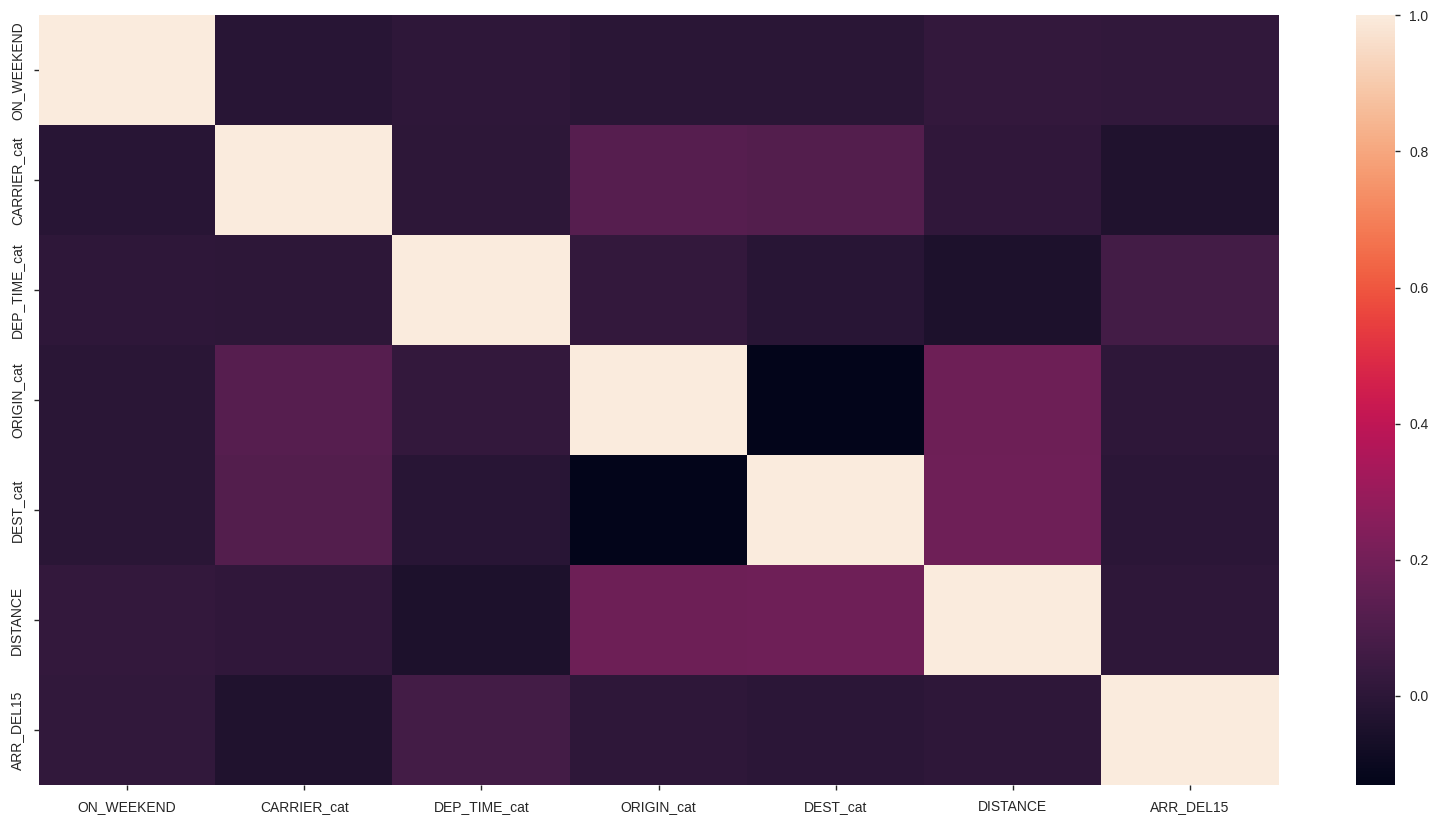

In [ ]:
plt.figure(figsize=(20,10))
sn.heatmap(df.corr())

# Построение моделей

Удаляем target переменную из x, выделяем ее в y

In [ ]:
df_X = df.drop('ARR_DEL15', axis=1)
df_y = df[['ARR_DEL15']]
X = df_X.values
y = df_y.values

Используем OneHotEncoder с помощью LabelBinarizer

In [ ]:
y = LabelBinarizer().fit_transform(y)

df_y.value_counts()

ARR_DEL15
0.0          977724
1.0          187507
dtype: int64

Построим графики аномалий, видим что наши данные неравномерно распеределены, то есть у нас в target дисбаланс

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

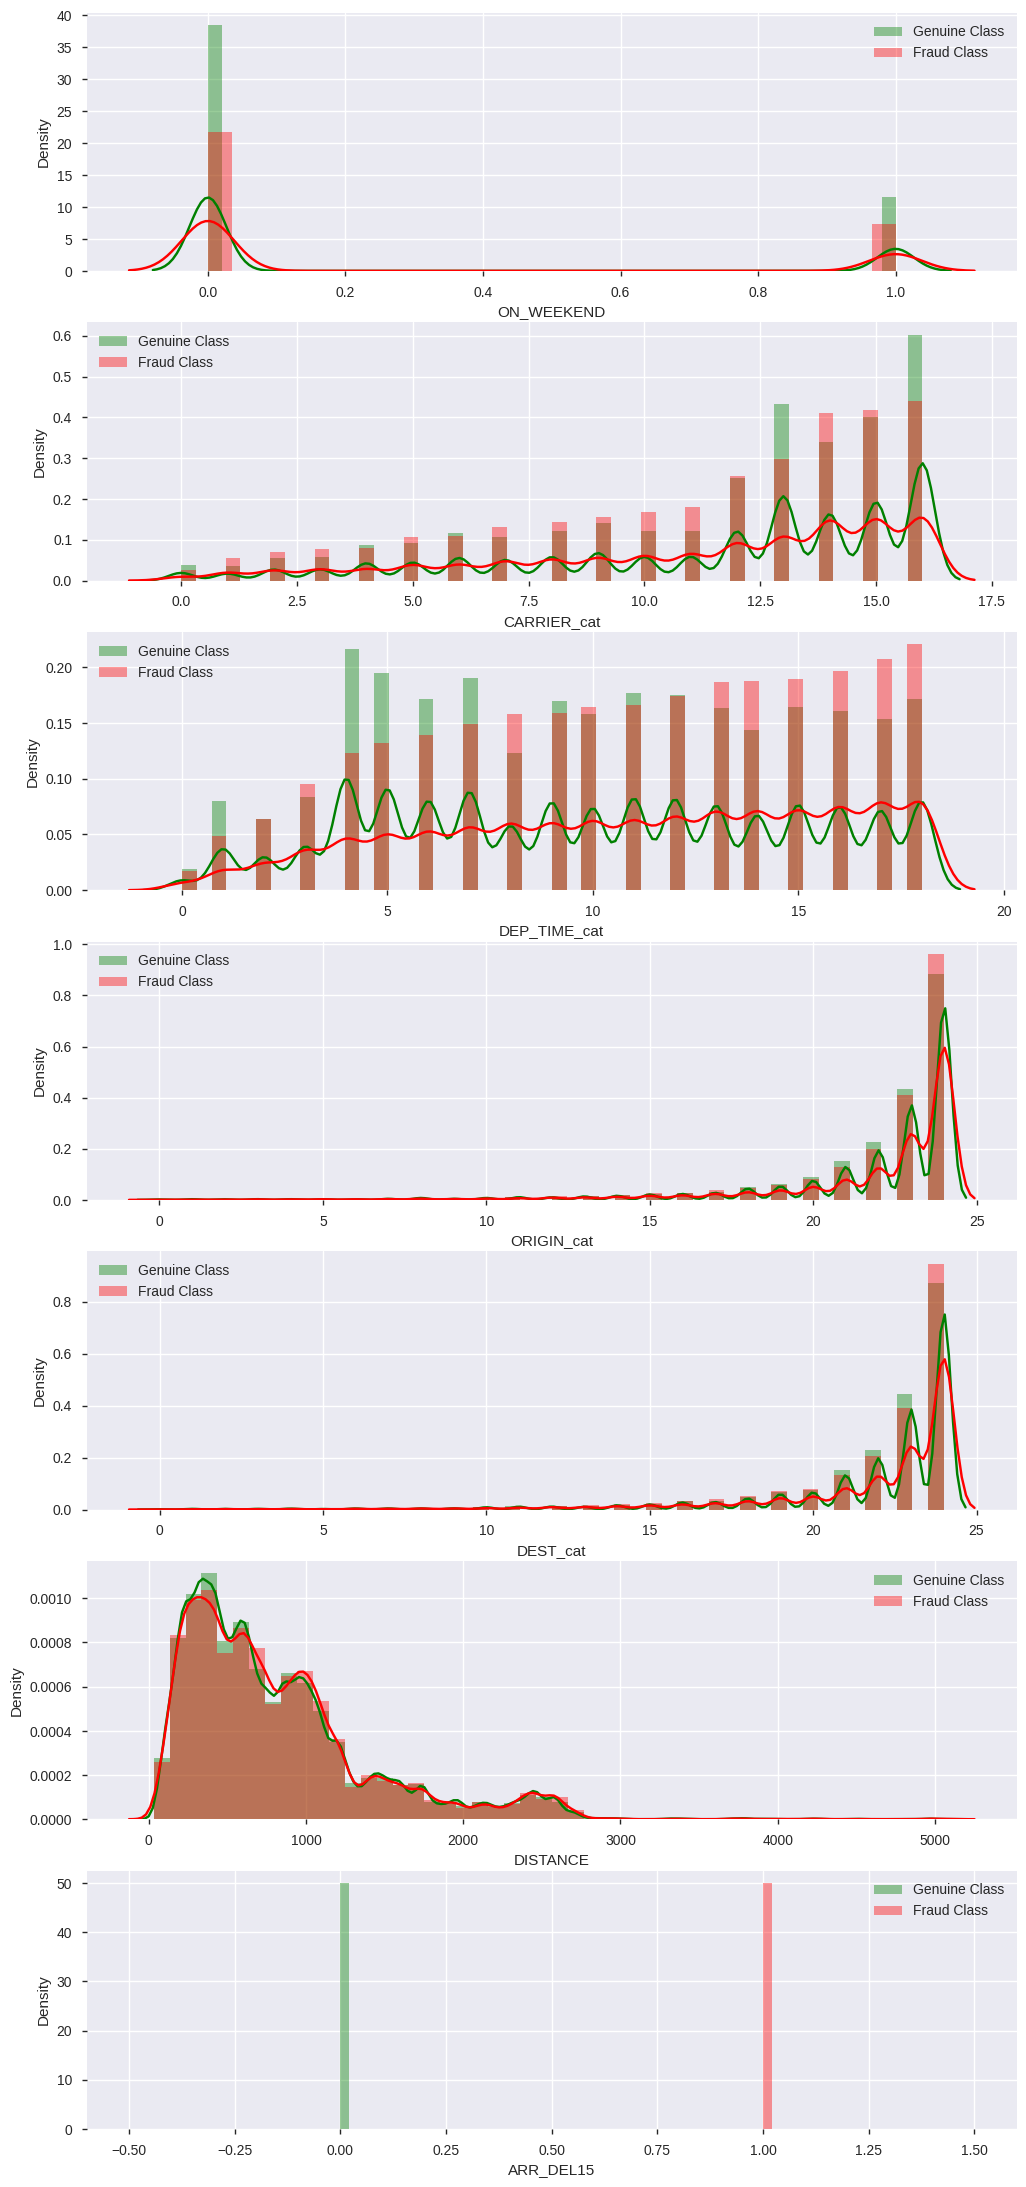

In [ ]:
v_features = df.columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31,1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sn.distplot(df[col][df['ARR_DEL15']==0],color='g',label='Genuine Class')
    sn.distplot(df[col][df['ARR_DEL15']==1],color='r',label='Fraud Class')
    ax.legend()
plt.show()

Для решения дисбаланса используем SMOTE (метод передискретизации синтетического меньшинства) 
Потом нормализуем наши данные

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

### DecisionTreeClassifier

Разбиваем наши данные на тестовую и обучающую выборку. И выбираем параметры с помощью GridSearchCV.
Строим модель по DecisionTreeClassifier и по
AUC ROC оцениваем эффективность нашей модель

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)
model = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, random_state=42)
model = model.fit(X_train, y_train)

# parameters = {'min_samples_split': np.arange(2, 10),
#                   'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 8)}
# model_decision_grid = DecisionTreeClassifier()
# model_grid = GridSearchCV(model_decision_grid, parameters, cv=5)
# model_grid.fit(X_train, y_train)
# print(model_grid.best_params_)

Выводим все наши данные и строим roc - кривую

[[145272  50249]
 [ 47988 147581]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.75    195521
           1       0.75      0.75      0.75    195569

    accuracy                           0.75    391090
   macro avg       0.75      0.75      0.75    391090
weighted avg       0.75      0.75      0.75    391090



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


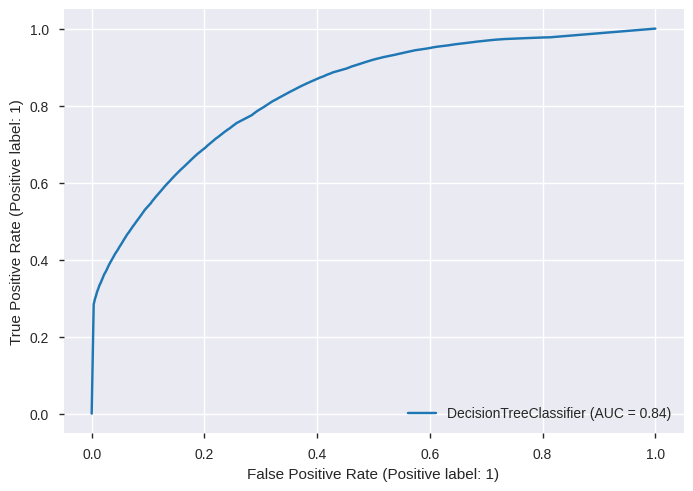

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

plot_roc_curve(model, X_test, y_test)

Сопоставляем предсказания и реальность используя матрицу ошибок

Text(0.5, 1.0, 'Normalized Confusion Matrix - Test Data')

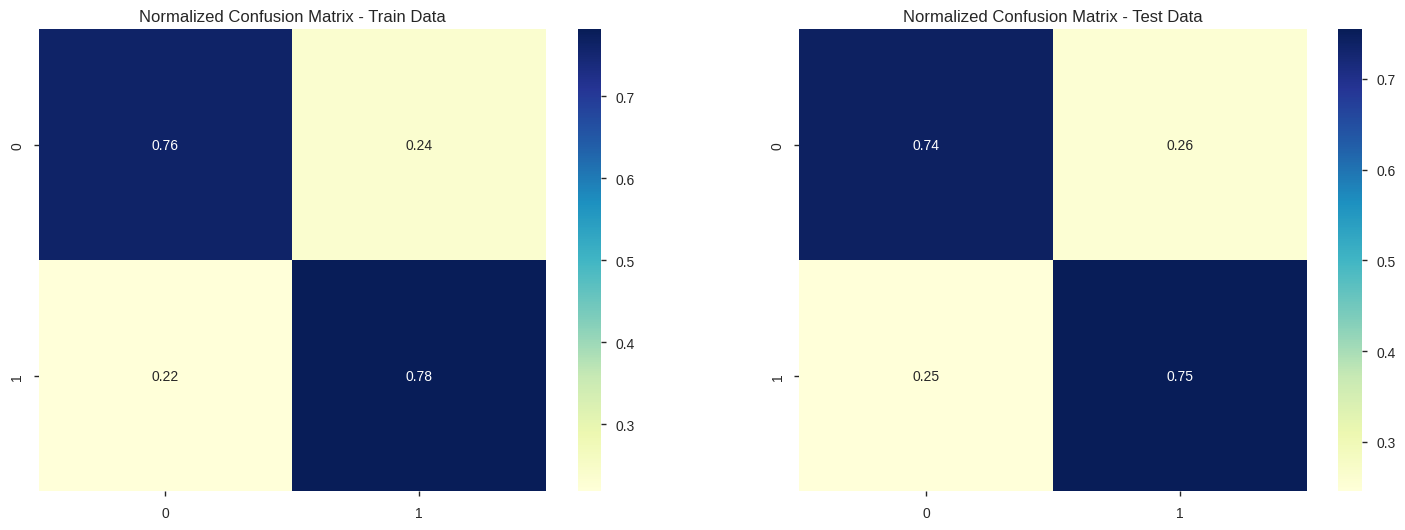

In [ ]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0])
cnf_matrix = confusion_matrix(y_train,y_pred_train)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Train Data")

ax2 = plt.subplot(gs[1])
cnf_matrix = confusion_matrix(y_test,y_pred_test)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Test Data")

In [ ]:
model.feature_importances_

array([0.19568714, 0.10051275, 0.26548408, 0.07642135, 0.0749675 ,
       0.2869272 ])

### CatBoostClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)
model = CatBoostClassifier(learning_rate=0.8, loss_function='Logloss',
                              logging_level='Verbose', l2_leaf_reg=3)
model = model.fit(X_train, y_train)

0:	learn: 0.6255053	total: 653ms	remaining: 10m 52s
1:	learn: 0.6127451	total: 1.01s	remaining: 8m 25s
2:	learn: 0.6067300	total: 1.3s	remaining: 7m 12s
3:	learn: 0.6009642	total: 1.61s	remaining: 6m 42s
4:	learn: 0.5964409	total: 1.91s	remaining: 6m 20s
5:	learn: 0.5943946	total: 2.22s	remaining: 6m 8s
6:	learn: 0.5902796	total: 2.53s	remaining: 5m 58s
7:	learn: 0.5884134	total: 2.82s	remaining: 5m 50s
8:	learn: 0.5845897	total: 3.13s	remaining: 5m 45s
9:	learn: 0.5792894	total: 3.46s	remaining: 5m 42s
10:	learn: 0.5769010	total: 3.78s	remaining: 5m 40s
11:	learn: 0.5758432	total: 4.08s	remaining: 5m 35s
12:	learn: 0.5726959	total: 4.39s	remaining: 5m 33s
13:	learn: 0.5695775	total: 4.7s	remaining: 5m 30s
14:	learn: 0.5664372	total: 5s	remaining: 5m 28s
15:	learn: 0.5653007	total: 5.34s	remaining: 5m 28s
16:	learn: 0.5625739	total: 5.65s	remaining: 5m 26s
17:	learn: 0.5619557	total: 5.92s	remaining: 5m 23s
18:	learn: 0.5564483	total: 6.25s	remaining: 5m 22s
19:	learn: 0.5557529	total:

[[151630  44236]
 [ 64767 130457]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.74    195866
           1       0.75      0.67      0.71    195224

    accuracy                           0.72    391090
   macro avg       0.72      0.72      0.72    391090
weighted avg       0.72      0.72      0.72    391090



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


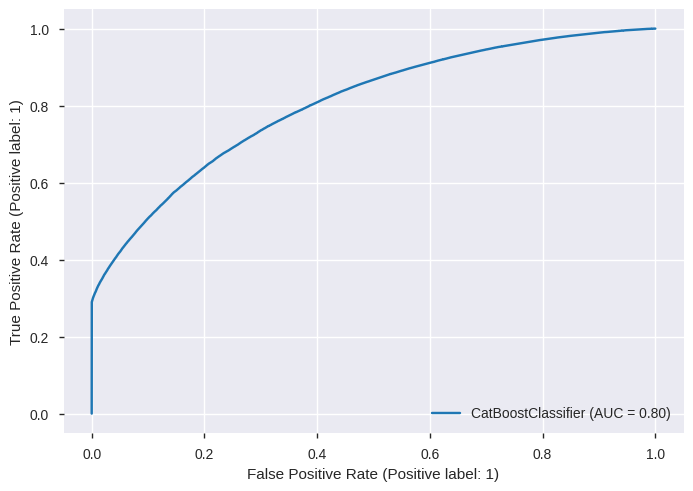

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

plot_roc_curve(model, X_test, y_test)

Text(0.5, 1.0, 'Normalized Confusion Matrix - Test Data')

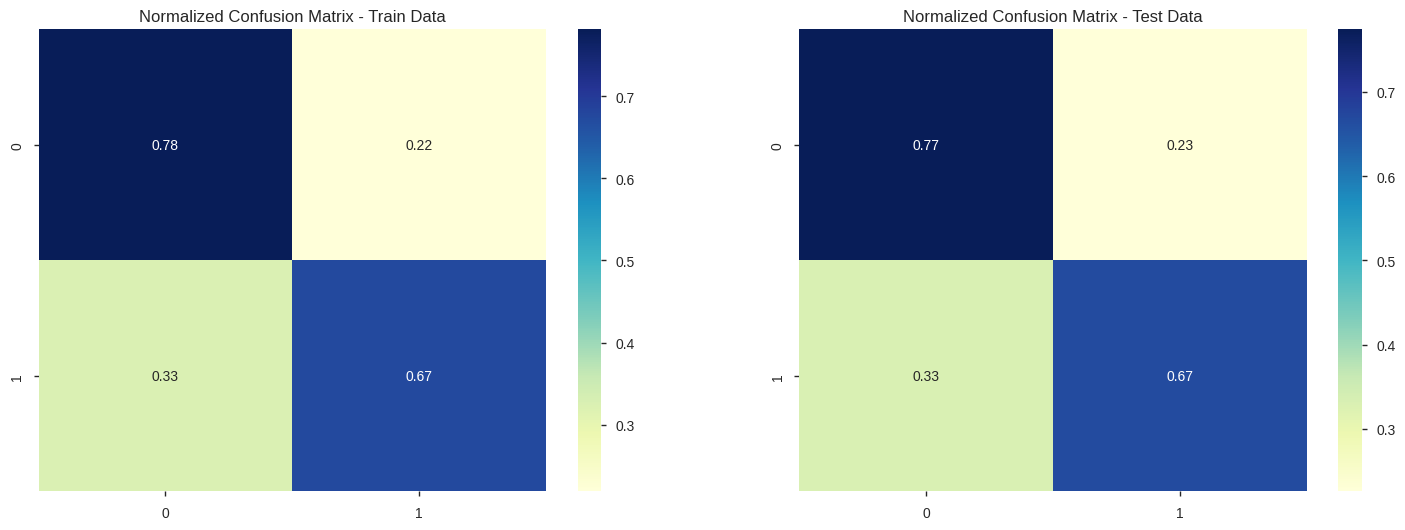

In [ ]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0])
cnf_matrix = confusion_matrix(y_train,y_pred_train)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Train Data")

ax2 = plt.subplot(gs[1])
cnf_matrix = confusion_matrix(y_test,y_pred_test)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Test Data")

###XGBClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

model = xgb.XGBClassifier(learning_rate=0.1,gamma=0.5, n_estimators=100,reg_alpha=1,reg_lambda=1.3, max_death=8,colsample_bytree=0.6,cv = 10, verbose = 3)
model = model.fit(X_train, y_train)

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.3, 2, 3, 4.5],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters,
#                              cv = 10, verbose = 3, random_state = 40 )
# xgb_rscv.fit(X_train, y_train)
# print(xgb_rscv.best_params_)

[[147312  48733]
 [ 79919 115126]]
              precision    recall  f1-score   support

           0       0.65      0.75      0.70    196045
           1       0.70      0.59      0.64    195045

    accuracy                           0.67    391090
   macro avg       0.68      0.67      0.67    391090
weighted avg       0.68      0.67      0.67    391090



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


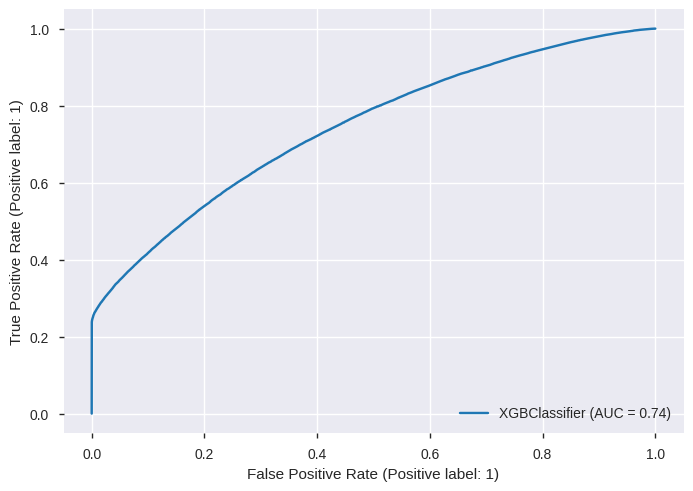

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

plot_roc_curve(model, X_test, y_test)

Text(0.5, 1.0, 'Normalized Confusion Matrix - Test Data')

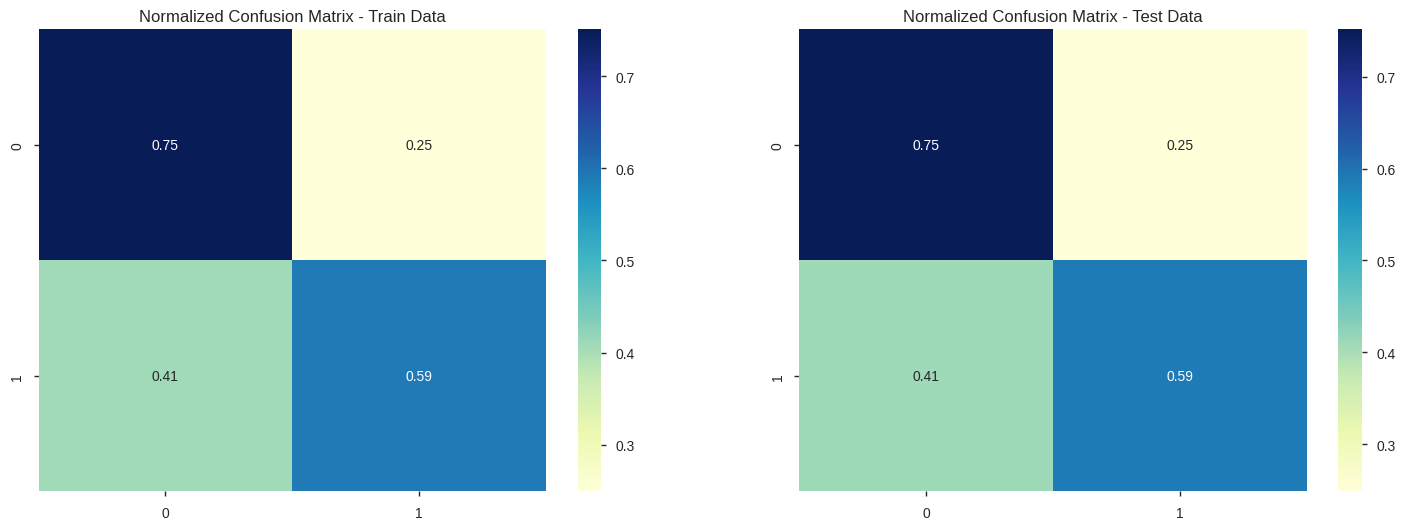

In [ ]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0])
cnf_matrix = confusion_matrix(y_train,y_pred_train)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Train Data")

ax2 = plt.subplot(gs[1])
cnf_matrix = confusion_matrix(y_test,y_pred_test)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum
sn.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Test Data")

#Вывод

**Таким образом, лучшую оценку мы получили на DecisionTreeClassifier. По auc она соcтавила 0.83.**